In [1]:
import math
import itertools

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import einops as E

/cbica/home/dadashkj/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from universeg import universeg


/cbica/home/dadashkj/.conda/envs/tf-gpu-jk/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
model = universeg(pretrained=True)
_ = model.to(device)

In [4]:
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

@torch.no_grad()
def inference(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    score = dice_score(hard_pred, label)

    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score}

In [5]:
from example_data.wbc import WBCDataset

d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
d_test = WBCDataset('JTSC', split='test', label='cytoplasm')

n_support = 48

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

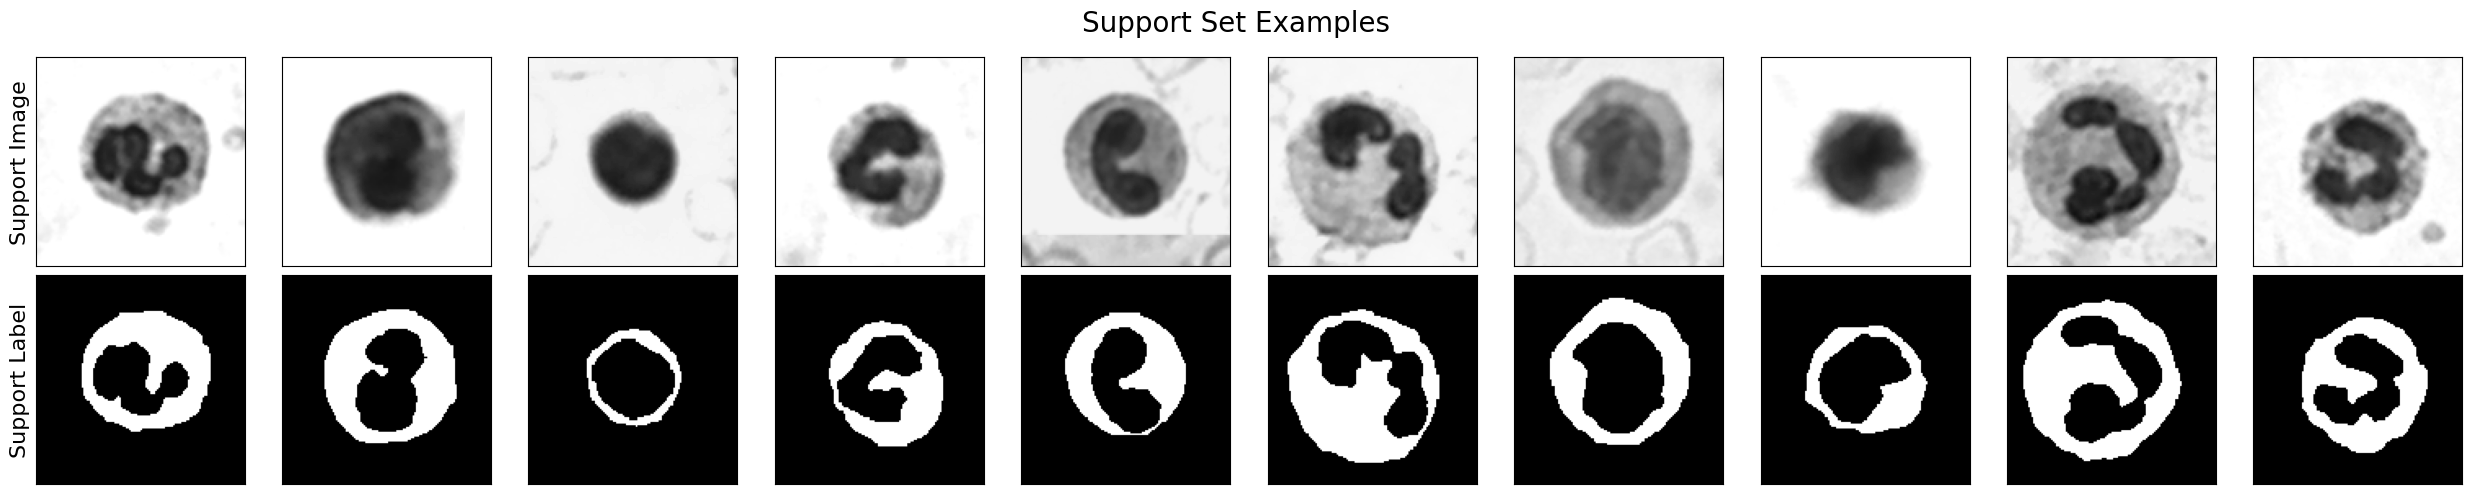

In [9]:
n_viz = 10
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=10, title='Support Set Examples')

# Test

[W626 11:56:48.751970248 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


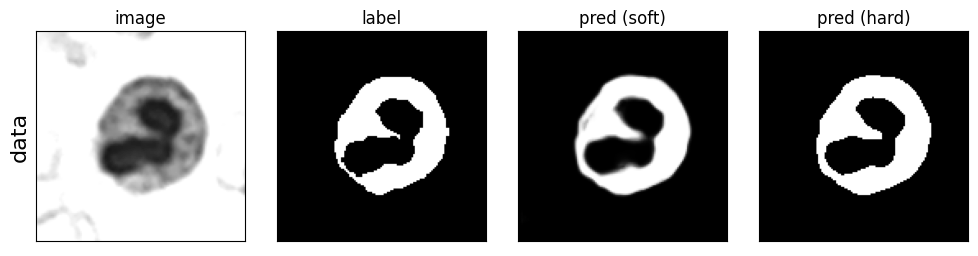

In [10]:
# select an image, label test pair
idx = np.random.permutation(len(d_test))[0]
image, label = d_test[idx]
image, label = image.to(device), label.to(device)

# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to('cpu')
pred = torch.sigmoid(logits)

# visualize
res = {'data': [image, label, pred, pred > 0.5]}
titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, col_names=titles)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:53<00:00, 17.31s/it]


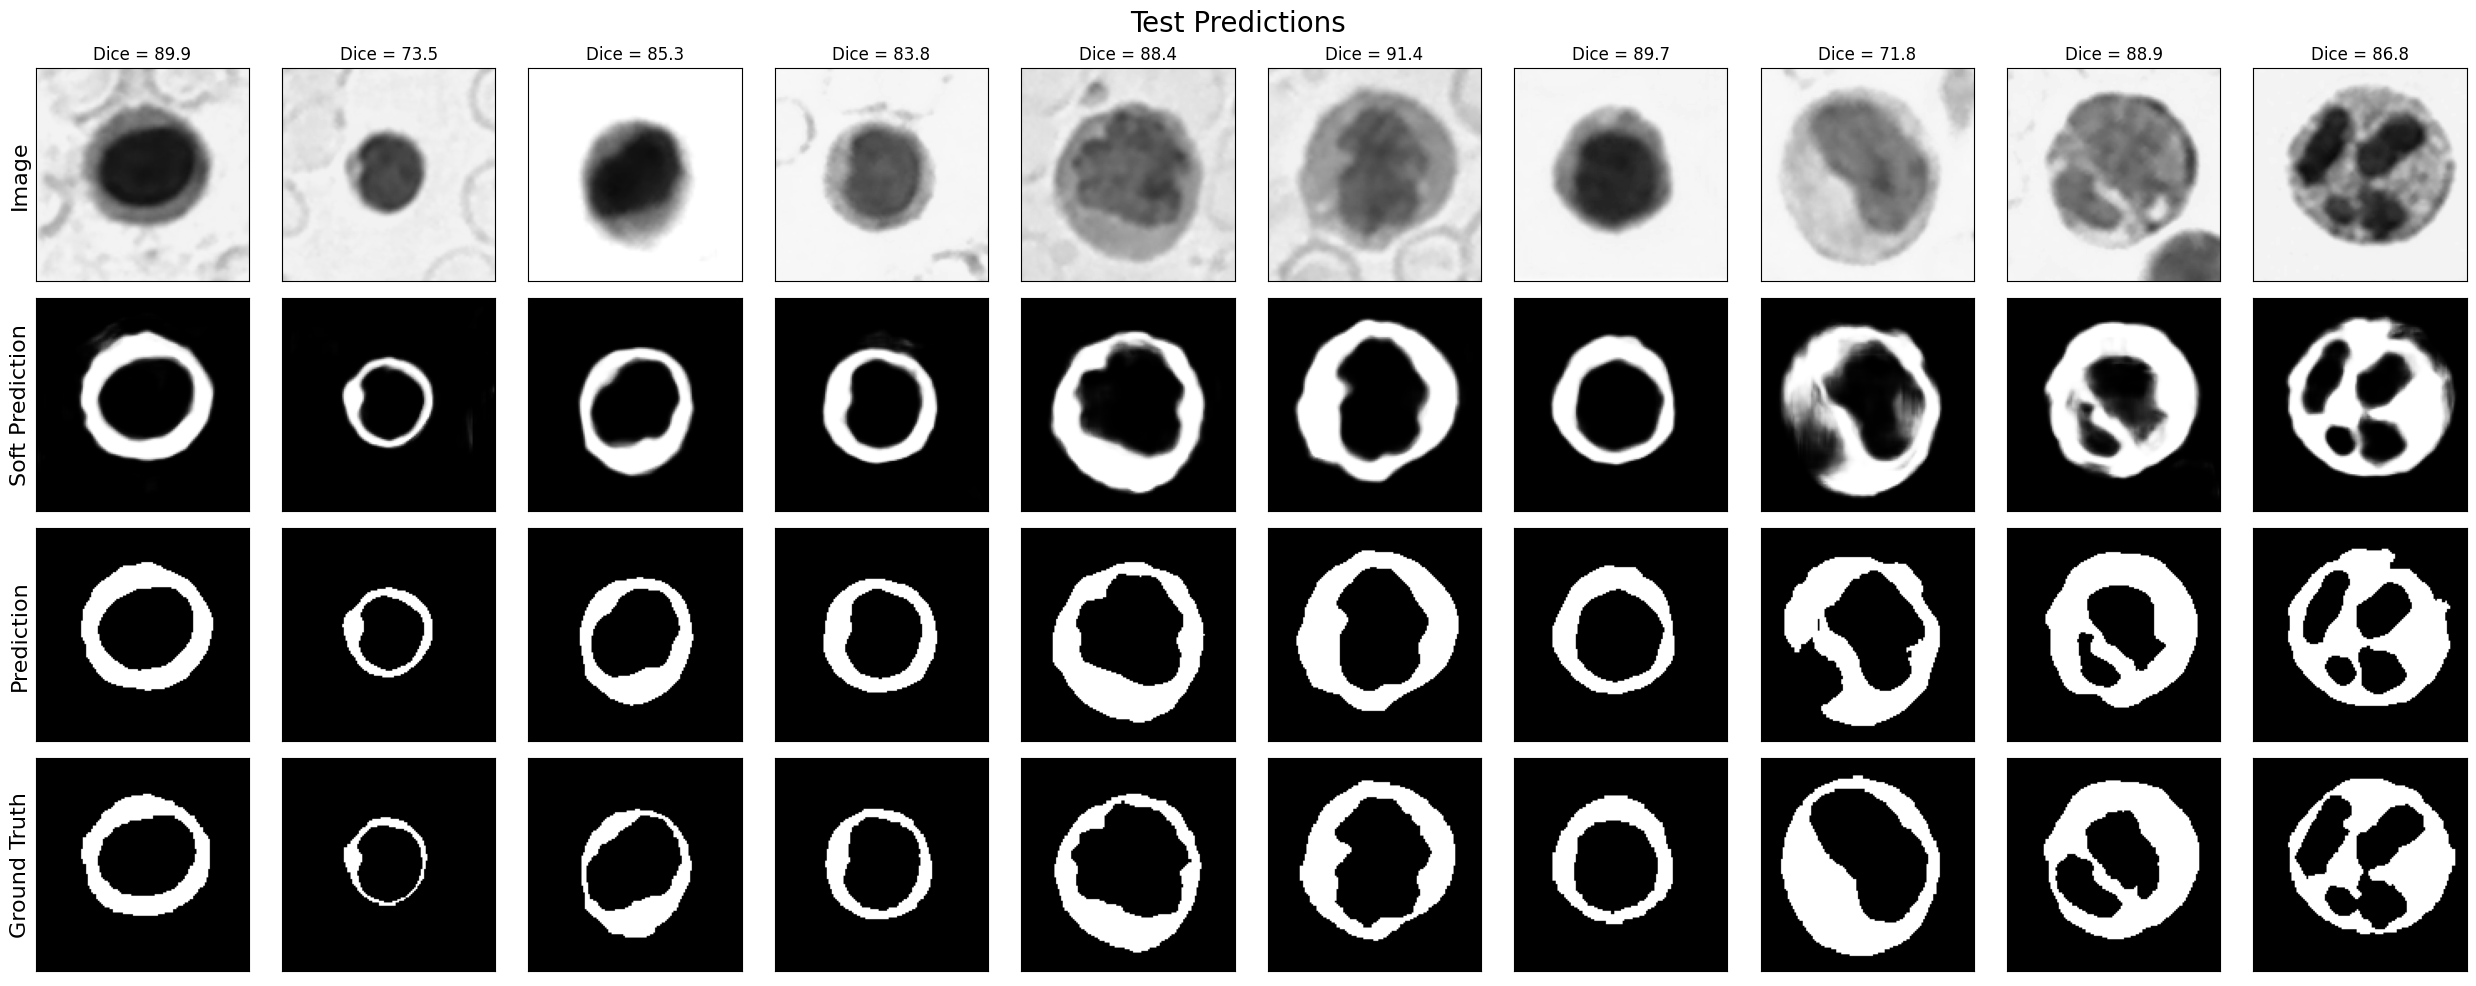

In [8]:
from collections import defaultdict

n_predictions = 10

results = defaultdict(list)

# compute inference and save predictions and metrics for n_predictions
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

# visualize the results, along with their scores
scores = results.pop('score')
visualize_tensors(results,
                  col_names=[f'Dice = {100*s:.1f}' for s in scores],
                  title='Test Predictions',
                  col_wrap=n_predictions)

Change support labels

Above, we showed results on the **cytoplasm** label in WBC.  
Here, we will show how we can easily get segmentations for another label (**nucleus**) in the same data by simply changing the support label images.

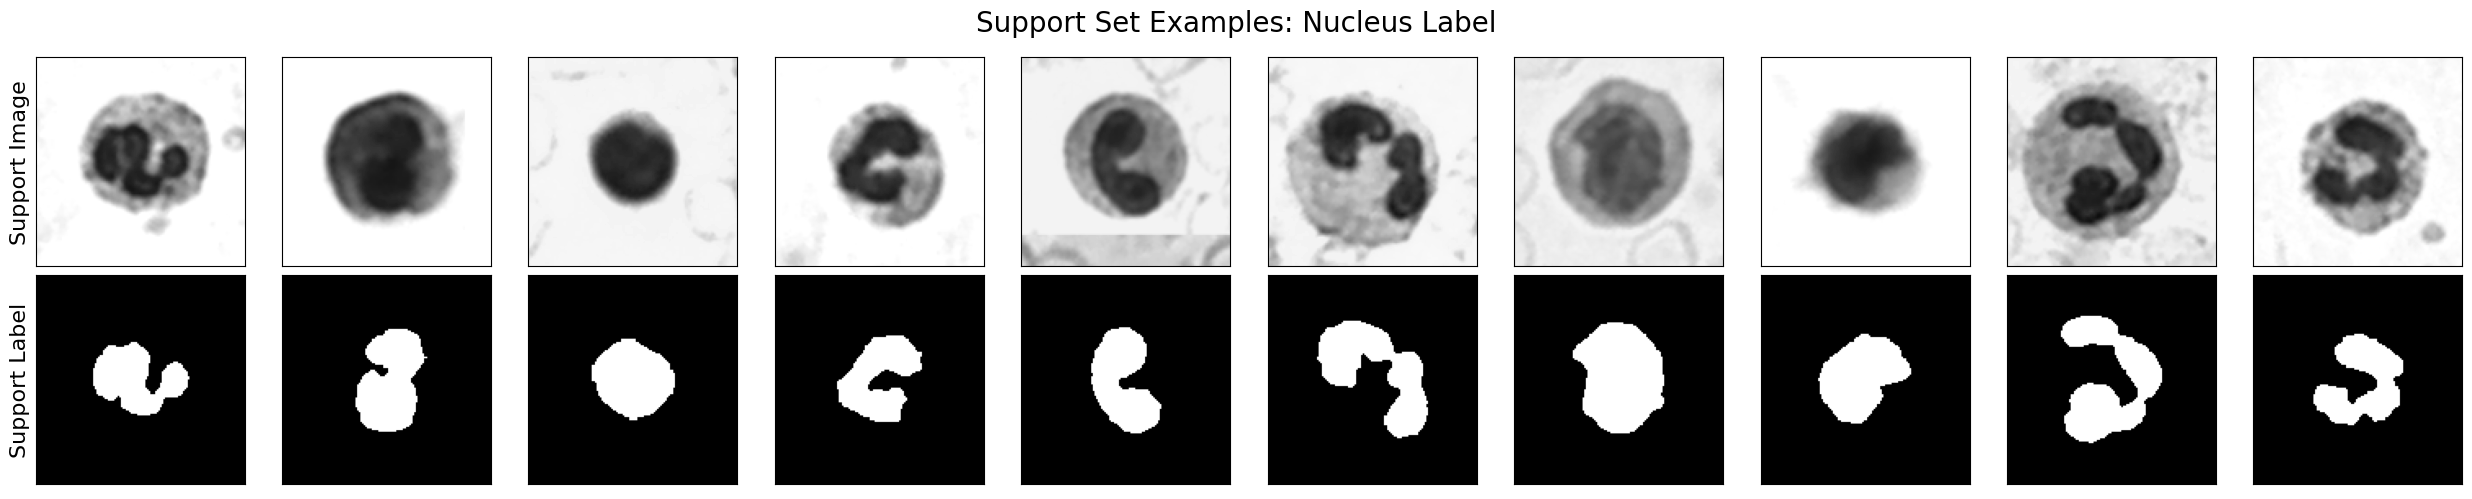

In [9]:
n_support = 64
# extract nucleus support data
d_support = WBCDataset('JTSC', split='support', label='nucleus')
d_test = WBCDataset('JTSC', split='test', label='nucleus')

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

# visualize nucleus support data
n_viz = 10
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=10, title='Support Set Examples: Nucleus Label')

# Test

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:49<00:00, 22.91s/it]


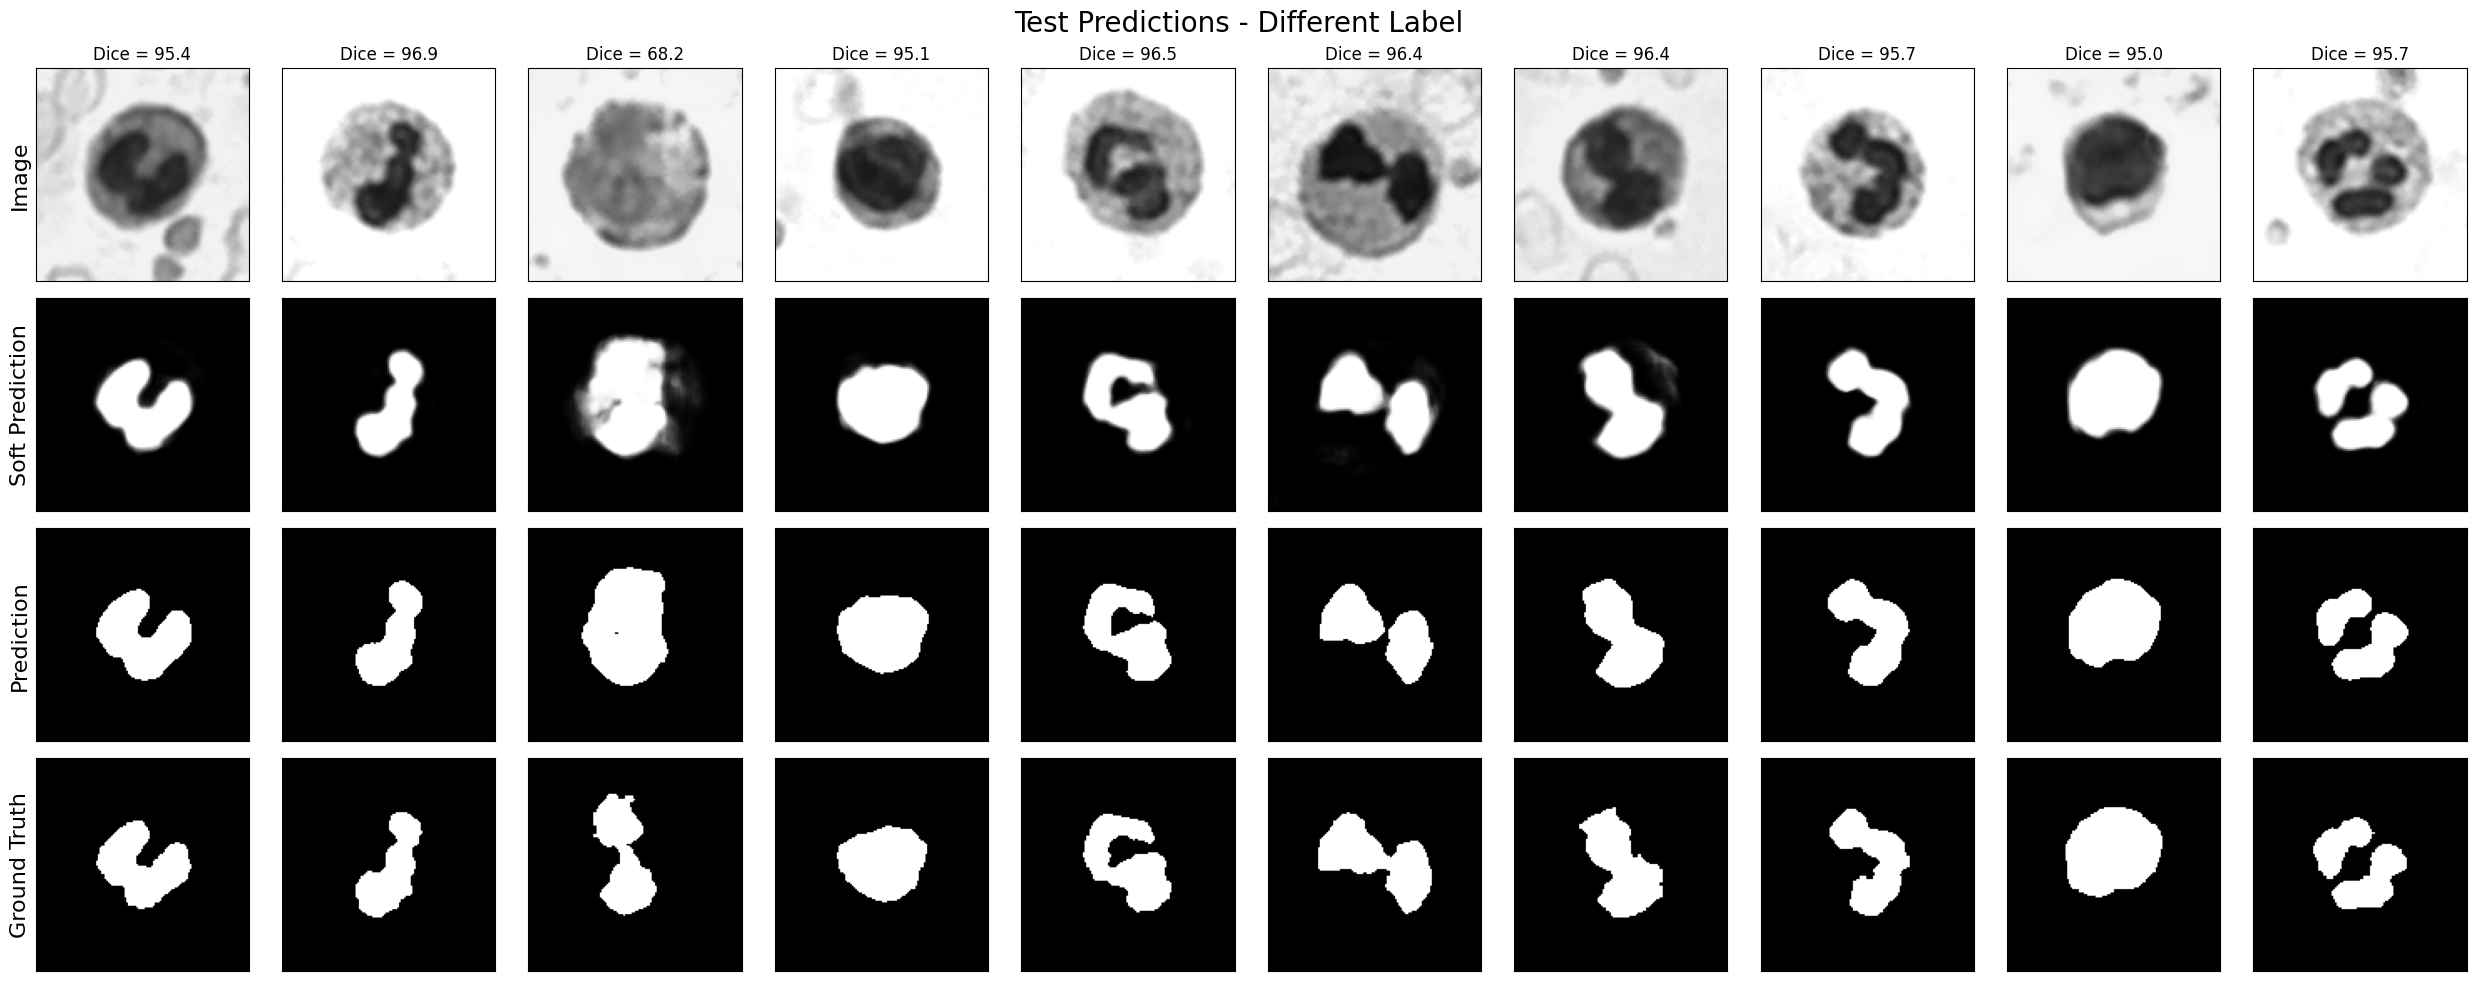

In [10]:
n_predictions = 10

results = defaultdict(list)

idxs = np.random.permutation(len(d_test))[:n_predictions]
for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

scores = results.pop('score')
visualize_tensors(results, col_names=[f'Dice = {100*s:.1f}' for s in scores], title='Test Predictions - Different Label', col_wrap=n_predictions)

# Effect of the Support Set Size

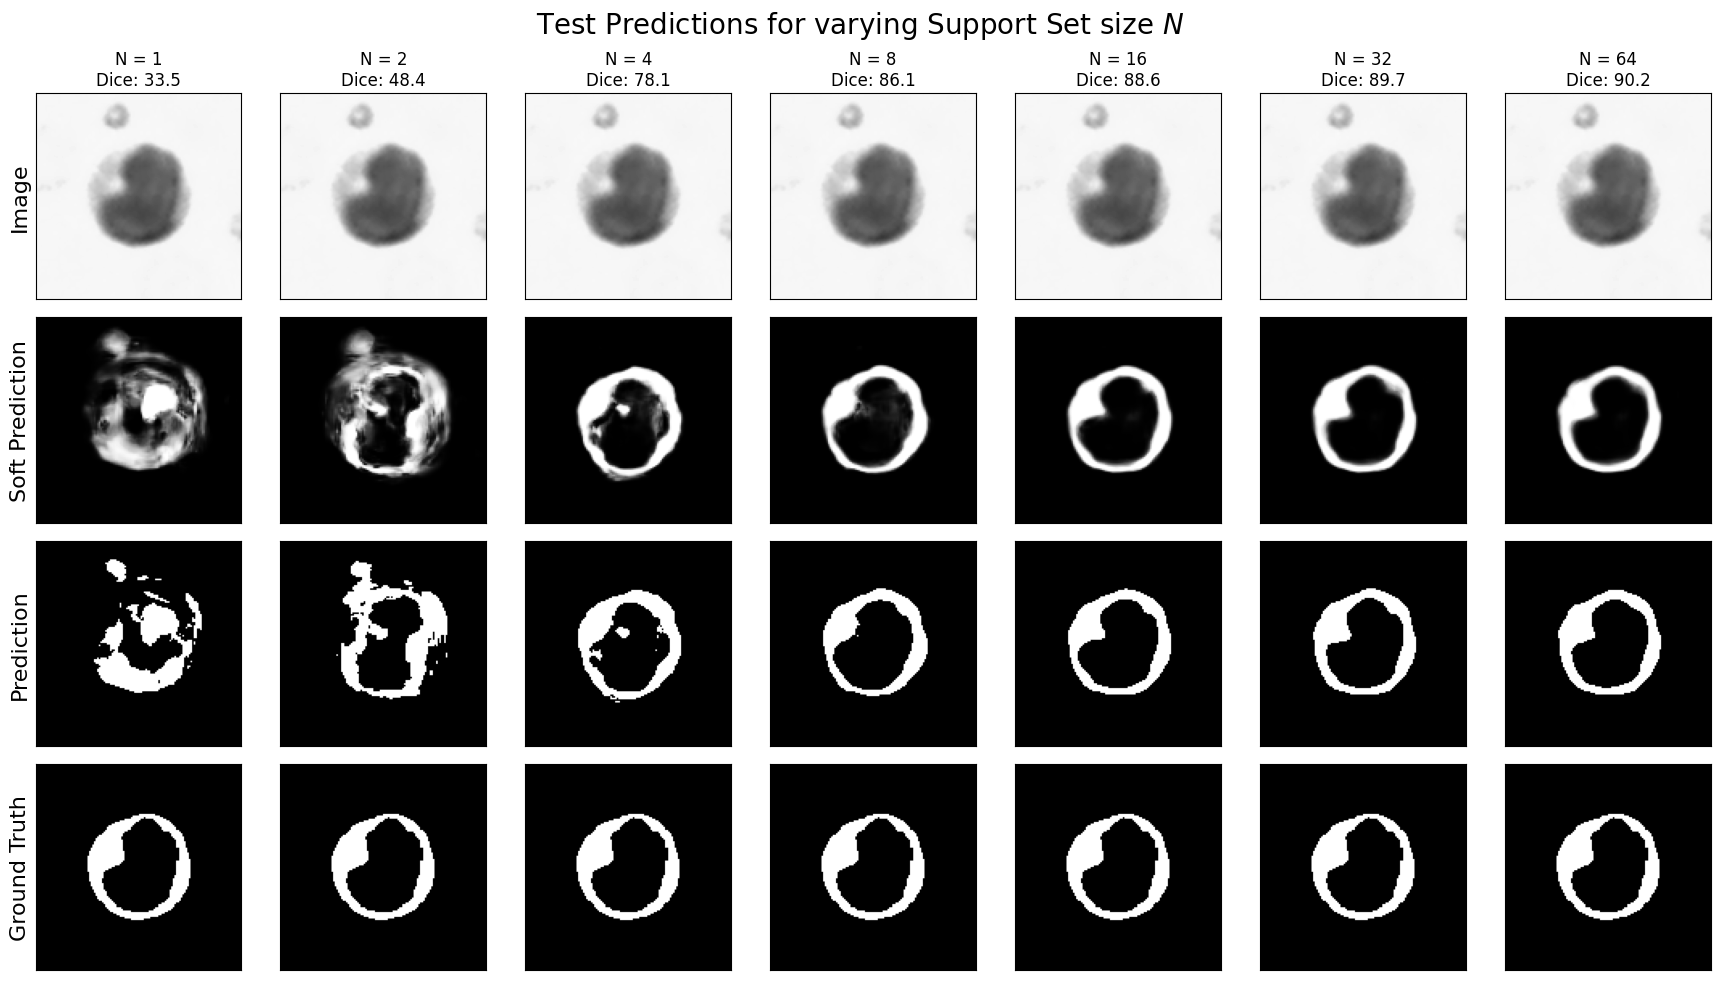

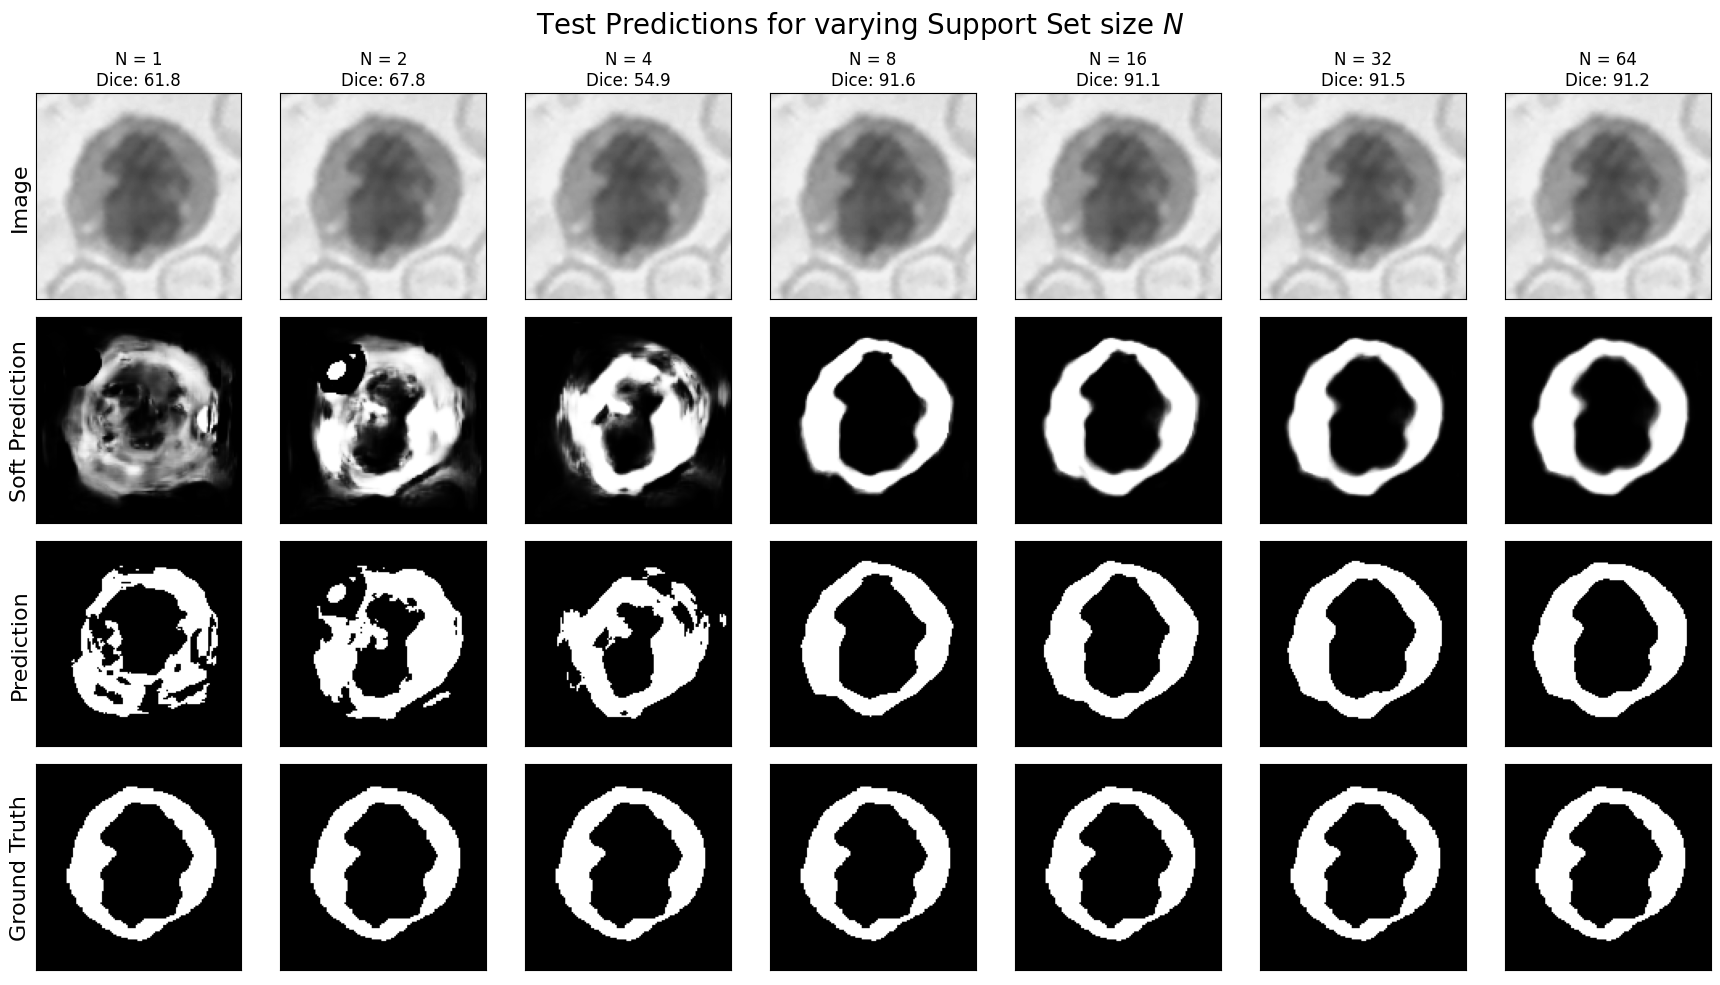

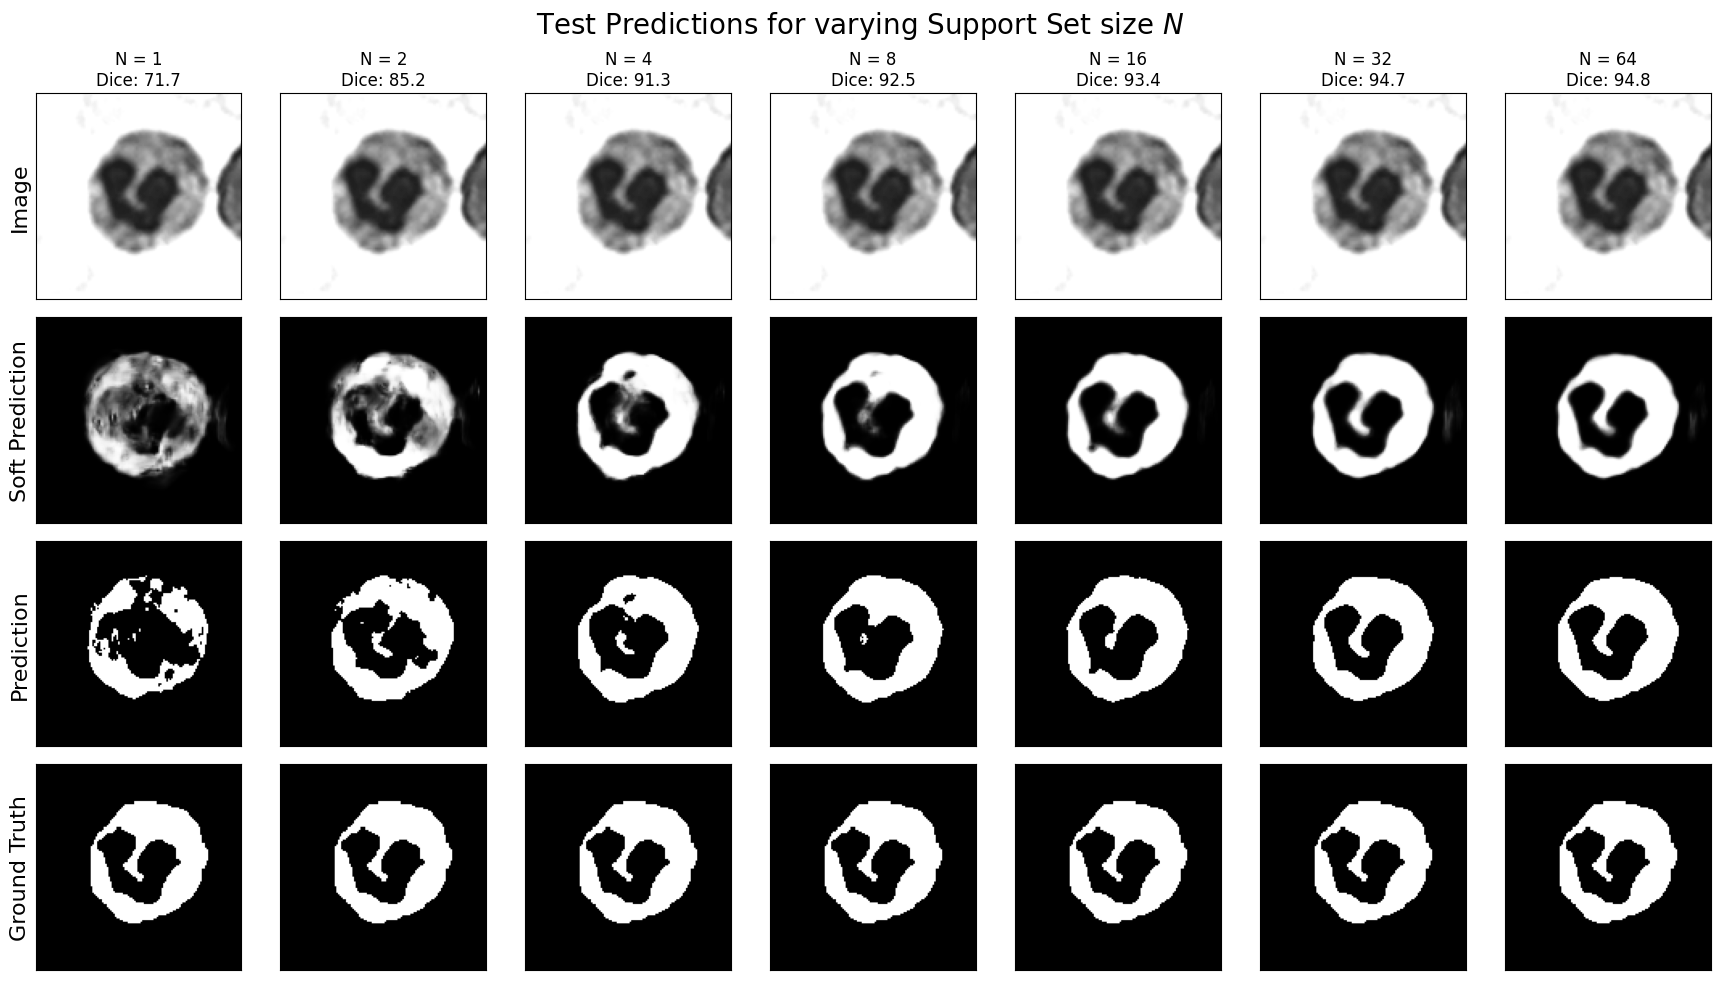

In [11]:
d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
d_test = WBCDataset('JTSC', split='test', label='cytoplasm')

n_support = 64

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

n_predictions = 3
support_set_sizes = [1, 2, 4, 8, 16, 32, 64]

idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in idxs:
    results = defaultdict(list)
    for N in support_set_sizes:
        image, label = d_test[i]
        vals = inference(model, image, label, support_images[:N], support_labels[:N])
        for k, v in vals.items():
            results[k].append(v)

    # visualize for this entry for different support sizes
    scores = results.pop('score')
    col_names = [f'N = {N}' for N in support_set_sizes]
    col_names = [col+f'\nDice: {100*score:.1f}' for col, score in zip(col_names, scores)]
    visualize_tensors(results, col_names=col_names, title='Test Predictions for varying Support Set size $N$', col_wrap=len(support_set_sizes))

# Pig

Creating support dataset from 7 folders...
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
Support dataset contains 1217 slices with non-zero masks.
Creating test dataset from 3 folders...
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEB

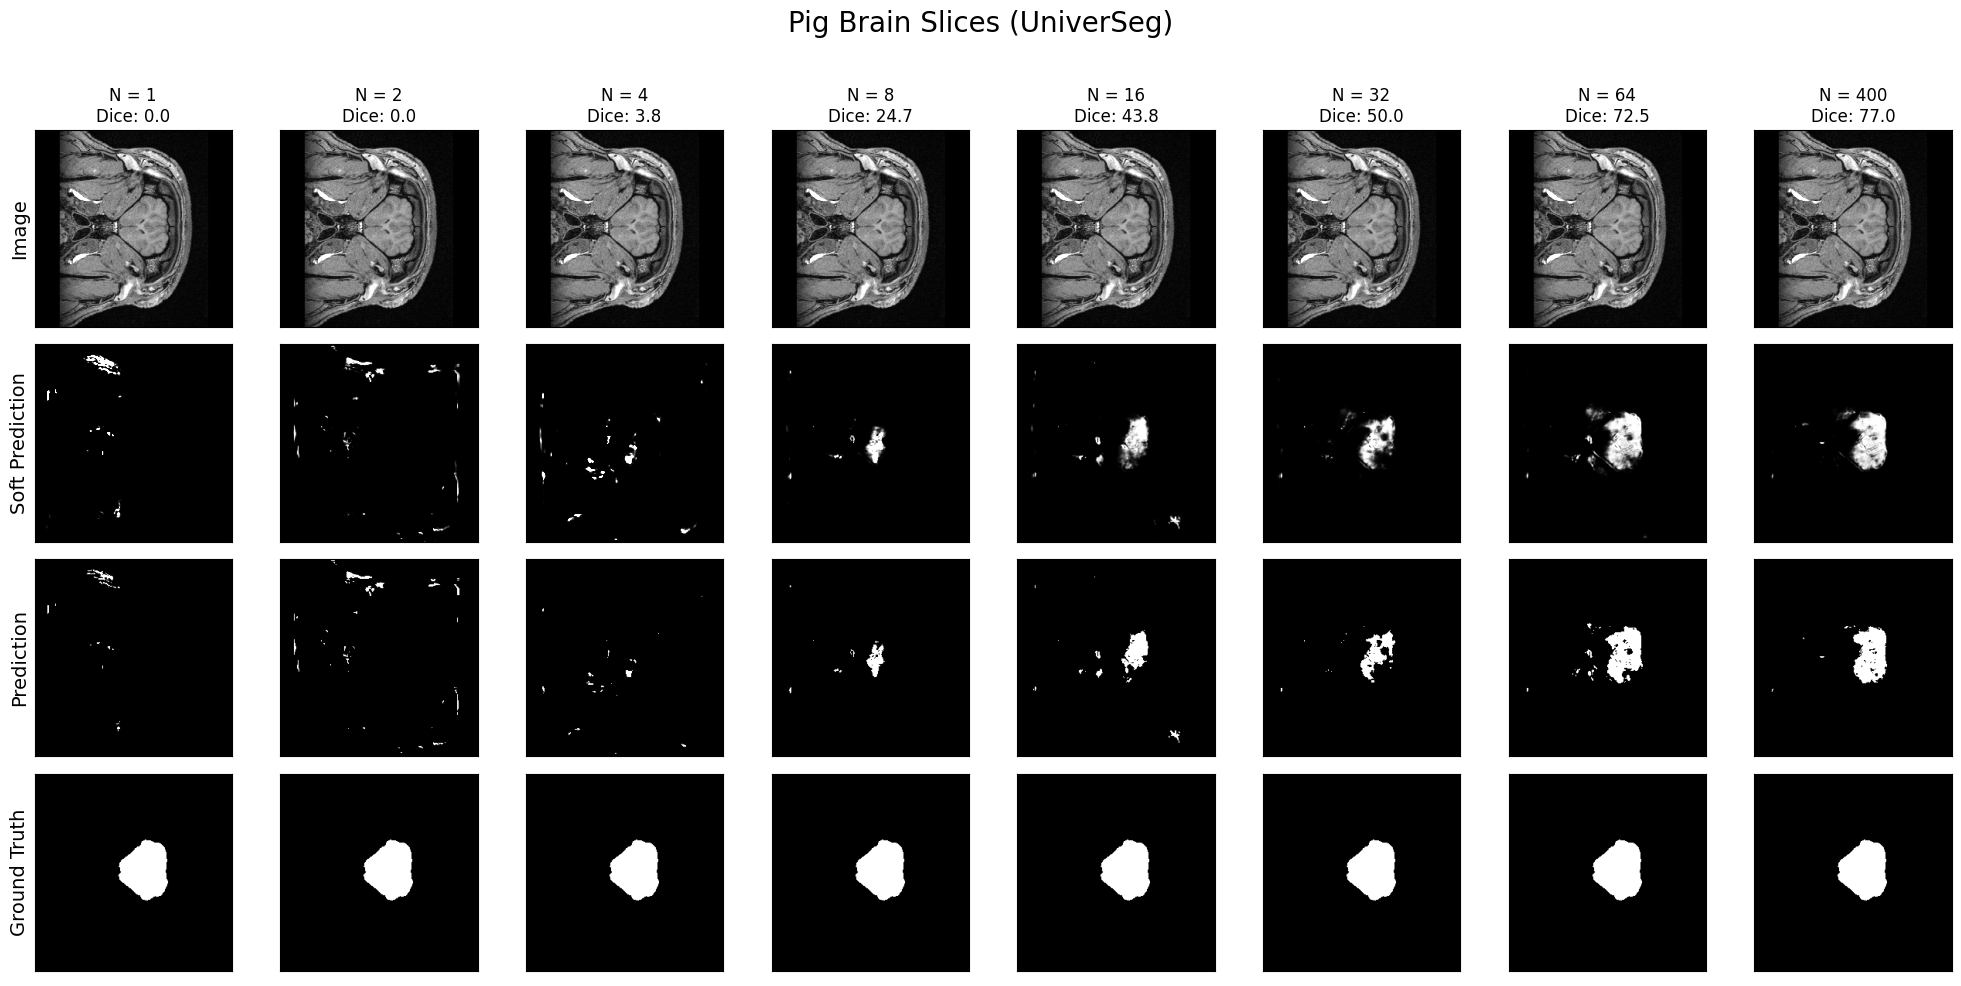

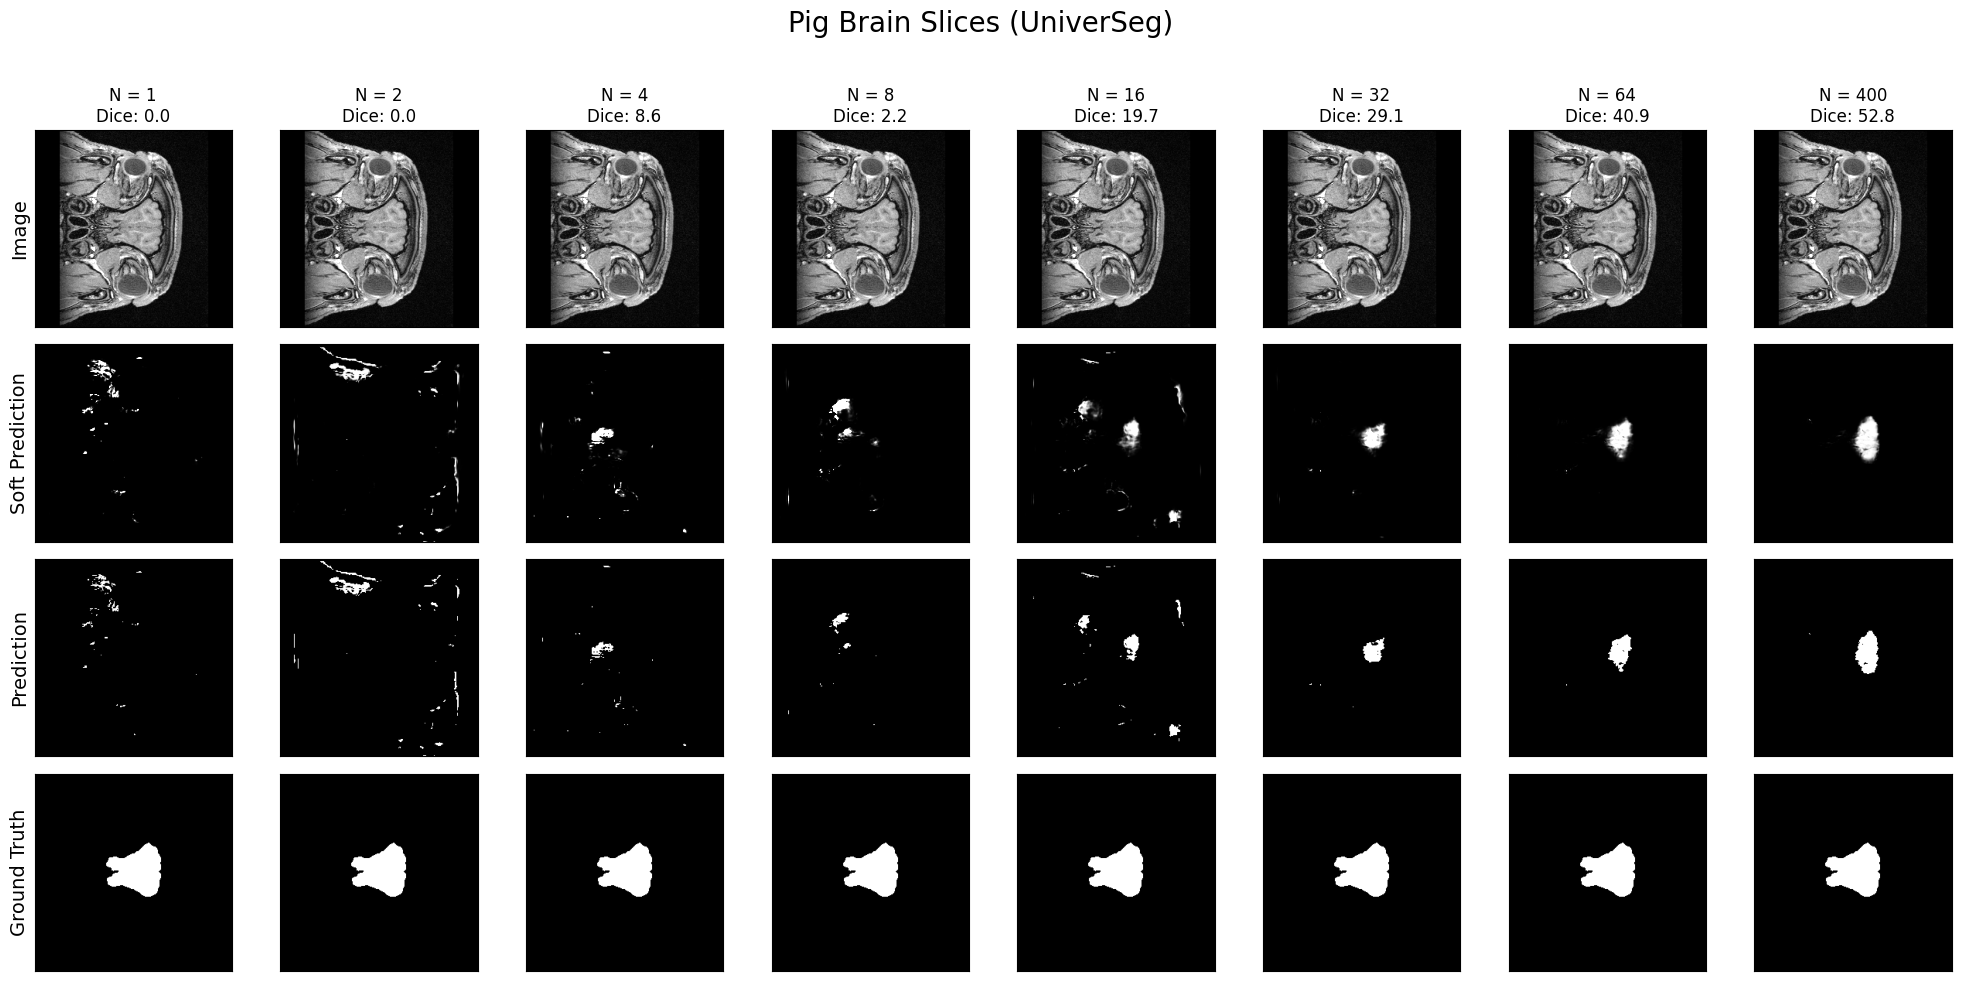

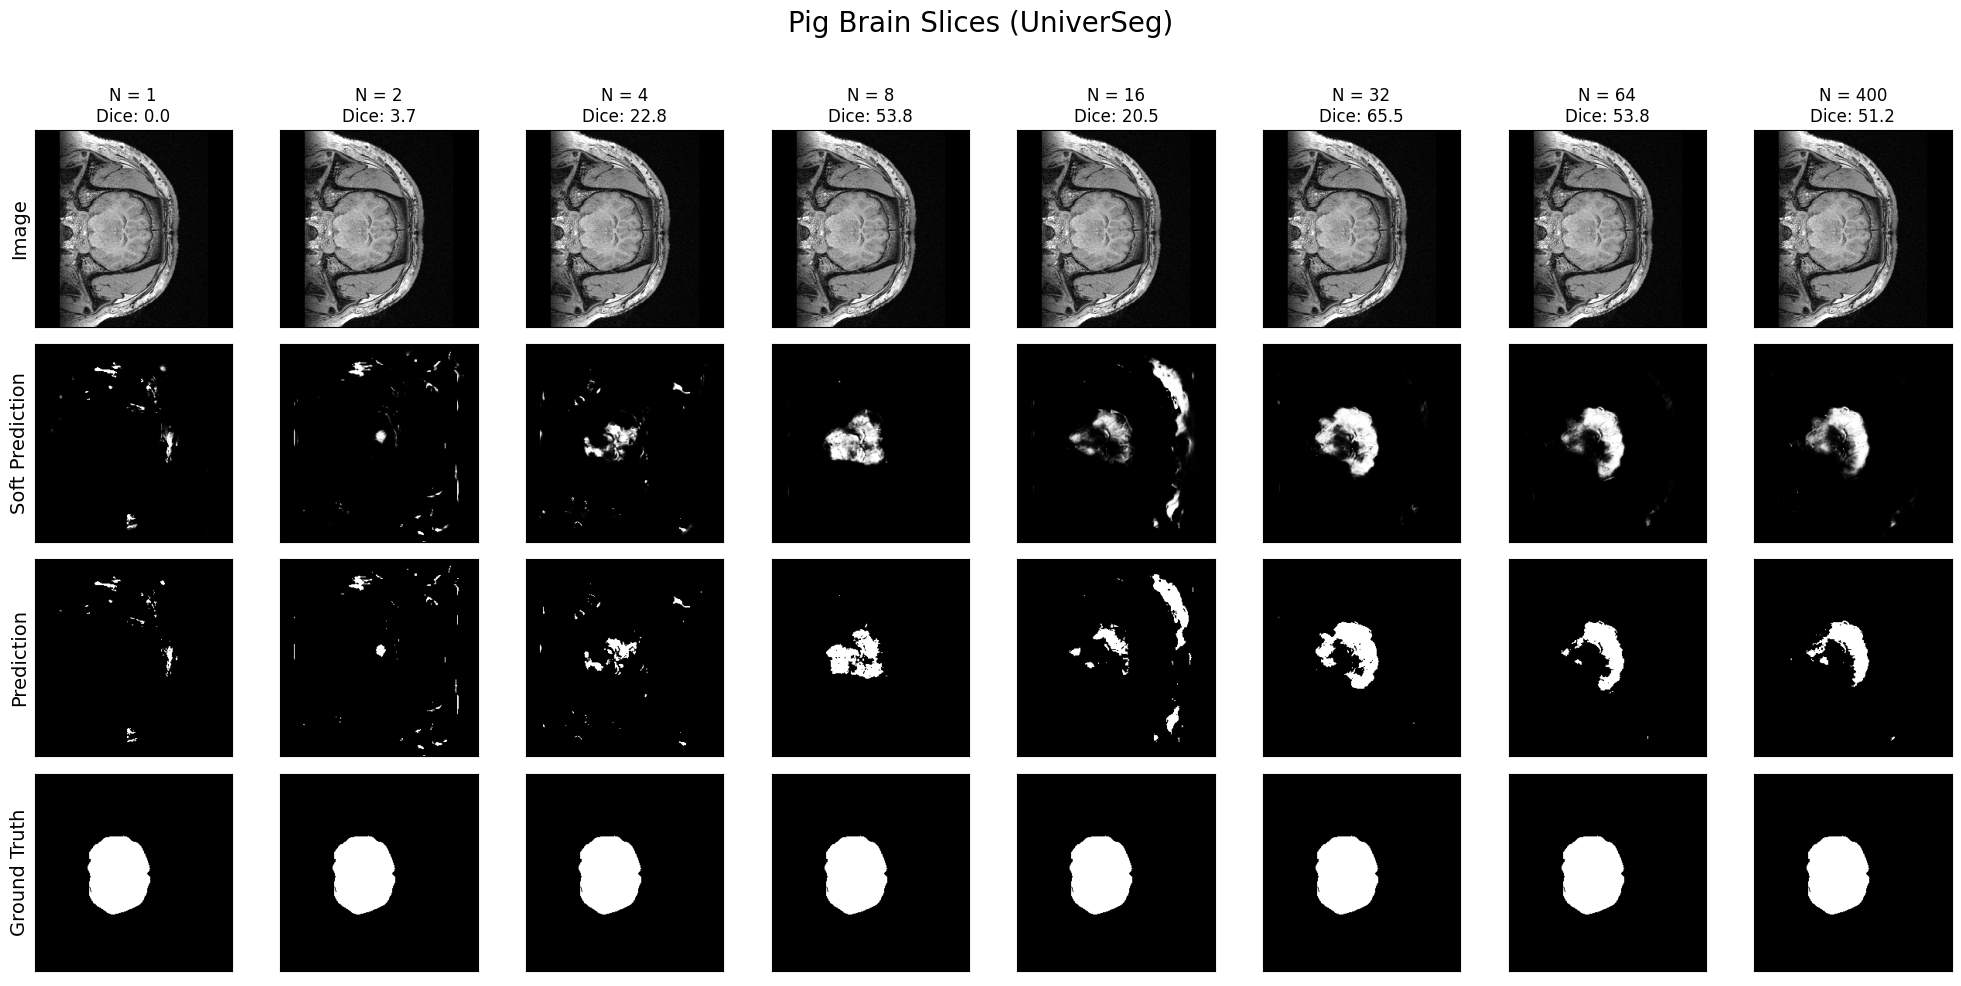

In [6]:
import os
import torch
import random
import numpy as np
from torch.utils.data import Dataset
import surfa as sf
import matplotlib.pyplot as plt # Import matplotlib for visualization
import math # Import math for ceil in visualize_tensors
from einops import rearrange as E # Import einops if 'E' is used for rearrange
from collections import defaultdict # Ensure defaultdict is imported

# Assumes param_3d.img_size_256 is defined
import param_3d
# Assuming utils and help are in your path and contain necessary functions like 'inference' and 'universeg'
from utils import *
from help import *

# Set device globally if not already done in utils or help
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
import numpy as np
import math
# Assuming E is einops.rearrange. If not, you'll need to define or import it.
# from einops import rearrange as E 

class PigSliceDataset(Dataset):
    def __init__(self, folders, axis=2):
        self.samples = []
        self.axis = axis  # 0 = sagittal, 1 = coronal, 2 = axial

        for folder in folders:
            try:
                # Keep filenames as 'anat' and 'anat_brain_olfactory_mask'
                pig_anat = self.load_volume_file(folder, 'anat')
                pig_mask = self.load_volume_file(folder, 'anat_brain_olfactory_mask')
                pig_mask = (pig_mask > 0).astype(np.uint8)

                num_slices = pig_anat.shape[self.axis]
                for i in range(num_slices):
                    if self.axis == 0:
                        img_slice = pig_anat[i, :, :]
                        mask_slice = pig_mask[i, :, :]
                    elif self.axis == 1:
                        img_slice = pig_anat[:, i, :]
                        mask_slice = pig_mask[:, i, :]
                    else: # self.axis == 2
                        img_slice = pig_anat[:, :, i]
                        mask_slice = pig_mask[:, :, i]

                    # Condition to only add slices with non-zero masks
                    if np.any(mask_slice > 0):
                        self.samples.append((img_slice, mask_slice))
                    # else:
                        # Optional: uncomment to see skipped slices
                        # print(f"Skipping empty mask slice {i} from {os.path.basename(folder)} (axis {self.axis}).")

            except FileNotFoundError as fnfe:
                print(f"⚠️ Skipping {folder}: {fnfe}")
            except Exception as e:
                print(f"⚠️ Skipping {folder} due to unexpected error: {e}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image, mask = self.samples[idx]

        # DO NOT CHANGE INTENSITY NORMALIZATION: Kept as / 255.0
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) / 255.0
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        return image, mask

    @staticmethod
    def load_volume_file(folder_path, file_name):
        for ext in ['.nii.gz', '.nii']:
            file_path = os.path.join(folder_path, file_name + ext)
            # print(f"Checking: {repr(file_path)}") # Keep this for debugging if needed
            if os.path.exists(file_path):
                # Ensure surfa is correctly configured and param_3d.img_size_256 is appropriate
                return sf.load_volume(file_path).reshape([param_3d.img_size_256]*3).data
        raise FileNotFoundError(f"{file_name} not found in {folder_path}")


folders_path = [
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/template/",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/81-T2",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/75",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/79-T2",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/79",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/78",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/106_6month/",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/82",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/101",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/93"
]

import matplotlib.pyplot as plt
import numpy as np

def plot_pig_brain_slices(volume, title="Pig Brain Anatomy", cmap='gray', vmin=0, vmax=1):
    """
    Plot orthogonal slices (axial, sagittal, coronal) of a 3D brain volume.

    Args:
        volume (numpy.ndarray): 3D array (Z, Y, X) representing the pig brain anatomy.
        title (str): Title of the plot.
        cmap (str): Colormap for display.
        vmin (float): Minimum intensity for visualization.
        vmax (float): Maximum intensity for visualization.
    """

    # Ensure volume is 3D
    if volume.ndim != 3:
        raise ValueError("Input volume must be a 3D array.")

    z, y, x = volume.shape
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(volume[z // 2, :, :], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[0].set_title("Axial (Z)")

    axes[1].imshow(volume[:, y // 2, :], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[1].set_title("Coronal (Y)")

    axes[2].imshow(volume[:, :, x // 2], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[2].set_title("Sagittal (X)")

    for ax in axes:
        ax.axis("off")

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


# Random shuffle for split
random.seed(42) # For reproducibility
random.shuffle(folders_path)
split_idx = int(0.7 * len(folders_path))
support_folders = folders_path[:split_idx]
test_folders = folders_path[split_idx:]

print(f"Creating support dataset from {len(support_folders)} folders...")
d_support = PigSliceDataset(support_folders)
print(f"Support dataset contains {len(d_support)} slices with non-zero masks.")

print(f"Creating test dataset from {len(test_folders)} folders...")
d_test = PigSliceDataset(test_folders)
print(f"Test dataset contains {len(d_test)} slices with non-zero masks.")


n_support = 400
# Ensure we don't try to sample more than available support samples
if len(d_support) < n_support:
    print(f"Warning: n_support ({n_support}) is greater than available support slices ({len(d_support)}). Adjusting n_support.")
    n_support = len(d_support)

if n_support == 0:
    print("Error: No support samples available after filtering for non-zero masks. Cannot proceed with inference.")
else:
    support_images, support_labels = zip(*random.sample(list(d_support), n_support))
    support_images = torch.stack(support_images).to(device)
    support_labels = torch.stack(support_labels).to(device)

    # Make sure universeg is defined and imported correctly
    model = universeg(pretrained=True).to(device)
    n_predictions = 3
    # Filter support_set_sizes if n_support is less than some values
    support_set_sizes = [N for N in [1, 2, 4, 8, 16, 32, 64, 400] if N <= n_support]
    if not support_set_sizes: # If all sizes are larger than actual n_support
        support_set_sizes = [n_support] # Use max available if smaller

    # Ensure there are enough test samples to draw predictions from
    if len(d_test) < n_predictions:
        print(f"Warning: n_predictions ({n_predictions}) is greater than available test slices ({len(d_test)}). Adjusting n_predictions.")
        n_predictions = len(d_test)

    if n_predictions == 0:
        print("Error: No test samples available after filtering for non-zero masks. Cannot generate predictions.")
    else:
        idxs = np.random.permutation(len(d_test))[:n_predictions]

        for i in idxs:
            results = defaultdict(list)
            for N in support_set_sizes:
                image, label = d_test[i]
                # 'inference' function from utils.py needs to be available
                vals = inference(model, image, label, support_images[:N], support_labels[:N])
                for k, v in vals.items():
                    results[k].append(v)

            # visualize results
            scores = results.pop('score')
            col_names = [f'N = {N}\nDice: {100*score:.1f}' for N, score in zip(support_set_sizes, scores)]
            visualize_tensors(results, col_names=col_names, title='Pig Brain Slices (UniverSeg)')

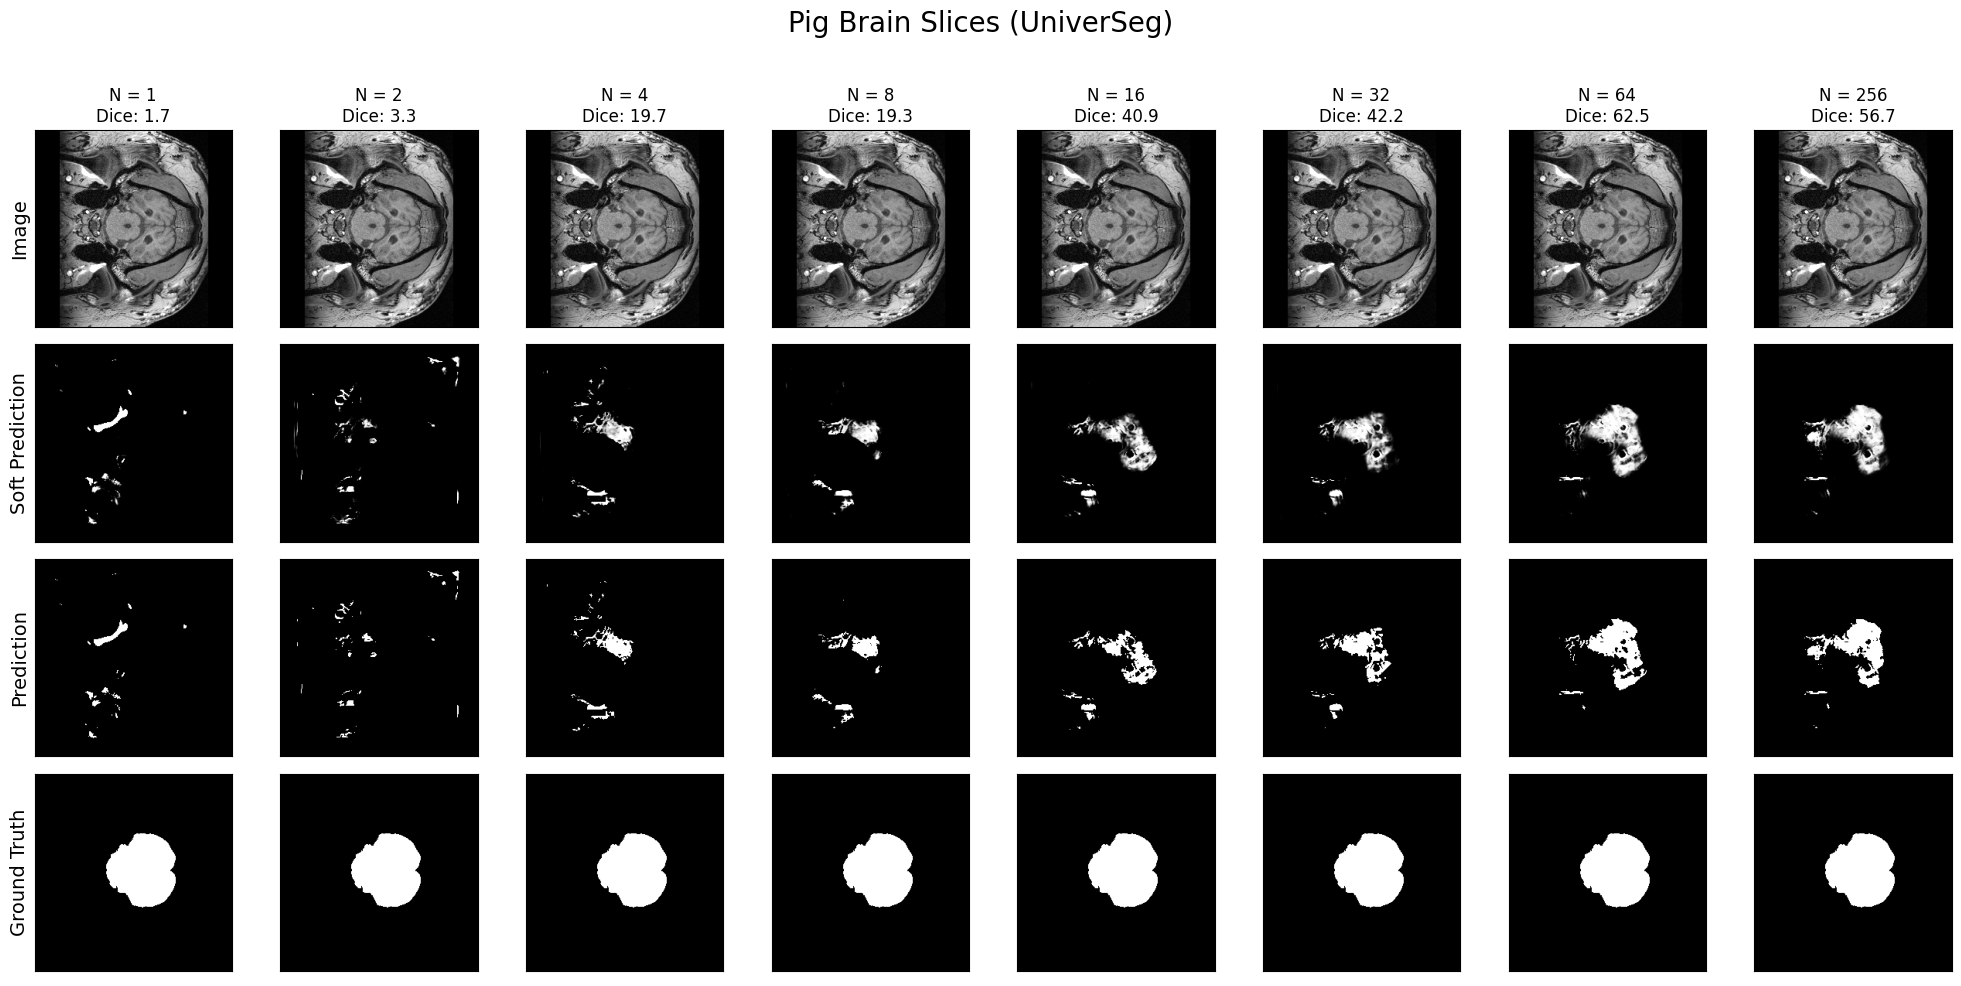

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch # Assuming you're working with PyTorch tensors

# If you use einops, uncomment this line.
# Make sure you have it installed: pip install einops
# try:
#     from einops import rearrange as E
# except ImportError:
#     E = None
#     print("Warning: einops not found. 3D tensor visualization might be limited.")



        
visualize_tensors(results, col_names=col_names, title='Pig Brain Slices (UniverSeg)')

In [ ]:
import os
import torch
import random
import numpy as np
from torch.utils.data import Dataset
import param_3d # Assumes param_3d.img_size_256 is defined
from utils import * # Assumed to contain 'universeg' and 'inference'
from help import * # Assuming other helper functions might be here
from medpy.metric.binary import dc, hd95
import nibabel as nib
import pandas as pd
from tqdm import tqdm
import re

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Dataset ----------
class PigSliceDataset(Dataset):
    def __init__(self, folders, axis=2):
        self.samples = []
        self.axis = axis
        for folder in folders:
            try:
                # PigSliceDataset still loads 'anat' and 'anat_brain_olfactory_mask'
                pig_anat = self.load_volume_file(folder, 'anat')
                pig_mask = self.load_volume_file(folder, 'anat_brain_olfactory_mask')
                pig_mask = (pig_mask > 0).astype(np.uint8) # Binarize mask

                for i in range(pig_anat.shape[self.axis]):
                    img_slice = np.take(pig_anat, i, axis=self.axis)
                    mask_slice = np.take(pig_mask, i, axis=self.axis)
                    if np.any(mask_slice):  # Only use support slices with non-zero mask
                        self.samples.append((img_slice, mask_slice))
                    # else:
                        # print(f"Skipping empty mask slice {i} from {os.path.basename(folder)}")
            except FileNotFoundError as fnfe:
                print(f"⚠️ Skipping {folder} (file not found for PigSliceDataset): {fnfe}")
            except Exception as e:
                print(f"⚠️ Skipping {folder} (general error in PigSliceDataset): {e}")

    # FIX: Removed the extra '(self)'
    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        image, mask = self.samples[idx]
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) / 255.0 # Intensity normalization kept as is
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        return image, mask

    @staticmethod
    def load_volume_file(folder_path, file_name):
        for ext in ['.nii.gz', '.nii']:
            file_path = os.path.join(folder_path, file_name + ext)
            if os.path.exists(file_path):
                # Ensure param_3d.img_size_256 is used correctly for reshaping if needed
                # (nibabel.load returns original size, surfa.load_volume handles reshape)
                # Your previous 'surfa' snippet had reshape, this one with nibabel does not.
                # If param_3d.img_size_256 is meant for input image size, ensure consistency.
                # Assuming images are already correctly sized or will be handled by the model
                return nib.load(file_path).get_fdata(dtype=np.float32)
        raise FileNotFoundError(f"{file_name} not found in {folder_path}")

# ---------- Batched Prediction Function ----------
def predict_universeg_3d(subject_folder, support_images, support_labels, model, batch_size=16):
    # This function expects 'image.nii' and 'mask_drew.nii'
    anat_path = None
    for ext in ['.nii.gz', '.nii']:
        test_path = os.path.join(subject_folder, "image" + ext)
        if os.path.exists(test_path):
            anat_path = test_path
            break
    if anat_path is None:
        raise FileNotFoundError(f"No image.nii[.gz] found in {subject_folder}")

    mask_path = None
    for ext in ['.nii.gz', '.nii']:
        test_mask_path = os.path.join(subject_folder, "mask_drew" + ext)
        if os.path.exists(test_mask_path):
            mask_path = test_mask_path
            break
    if mask_path is None:
        raise FileNotFoundError(f"No mask_drew.nii[.gz] found in {subject_folder}")

    vol_nii = nib.load(anat_path)
    vol_data = vol_nii.get_fdata(dtype=np.float32)
    vol_data = np.clip(vol_data, 0, 255) # Clipping intensity values
    affine = vol_nii.affine

    mask = nib.load(mask_path).get_fdata(dtype=np.float32)
    valid_slices = [i for i in range(mask.shape[2]) if np.any(mask[:, :, i] > 0)]
    if not valid_slices:
        print(f"Warning: No valid slices with non-zero mask found for {os.path.basename(subject_folder)}. Prediction will be an empty volume.")

    vol_tensor = torch.tensor(vol_data).permute(2, 0, 1).unsqueeze(1).to(device) / 255.0 # Intensity normalization kept as is
    pred_vol = torch.zeros_like(vol_tensor, dtype=torch.uint8) # Initialize on GPU

    model.eval()
    with torch.no_grad():
        # Iterate only through valid_slices
        for i in tqdm(range(0, len(valid_slices), batch_size), desc=f"Infer {os.path.basename(subject_folder)}"):
            batch_idxs = valid_slices[i:i+batch_size]
            batch_tensor = vol_tensor[batch_idxs] # [B, 1, H, W]

            B = batch_tensor.size(0)
            # Expand support tensors to match batch size
            sup_img = support_images.unsqueeze(0).expand(B, -1, -1, -1, -1)
            sup_lbl = support_labels.unsqueeze(0).expand(B, -1, -1, -1, -1)

            logits = model(batch_tensor, sup_img, sup_lbl)
            preds = torch.sigmoid(logits).round().clip(0, 1) # Binary prediction
            pred_vol[batch_idxs] = preds.byte()

    pred_np = pred_vol.squeeze(1).permute(1, 2, 0).cpu().numpy()
    save_path = os.path.join(subject_folder, "universeg.nii.gz") # Save as universeg.nii.gz
    # Save with original affine and ensure data type for NIfTI
    nib.save(nib.Nifti1Image(pred_np.astype(np.int32), vol_nii.affine), save_path)
    print(f"✅ Saved prediction for {os.path.basename(subject_folder)} to {save_path}")
    torch.cuda.empty_cache() # Clear GPU cache

# ---------- Evaluation ----------
def load_nifti(path): return nib.load(path).get_fdata()
def binarize(x): return (x > 0).astype(np.uint8)
def iou(a, b):
    intersection = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    return intersection / union if union > 0 else 0

def compute_stats(gt, pred):
    gt_bin = binarize(gt)
    pred_bin = binarize(pred)
    # Handle cases where one or both masks are entirely empty
    if np.sum(gt_bin) == 0 and np.sum(pred_bin) == 0:
        dice_val = 1.0
        hd95_val = 0.0
    elif np.sum(gt_bin) == 0 or np.sum(pred_bin) == 0:
        dice_val = 0.0
        hd95_val = np.inf # Or some large value indicating no overlap when one is empty
    else:
        dice_val = dc(pred_bin, gt_bin)
        hd95_val = hd95(pred_bin, gt_bin)
    return {
        "Dice": dice_val,
        "Hausdorff95": hd95_val,
        "IoU": iou(pred_bin, gt_bin)
    }

def extract_numeric_id(folder_name):
    m = re.search(r'(\d+)', folder_name)
    return m.group(1) if m else None

# ---------- Support Setup ----------
# These folders contain 'anat.nii' and 'anat_brain_olfactory_mask.nii'
folders_path = [
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/template/",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/81-T2",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/75",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/79-T2",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/79",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/78",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/106_6month/",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/82",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/101",
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/93"
]

random.seed(42) # For reproducibility
random.shuffle(folders_path)
split_idx = int(0.7 * len(folders_path))
support_folders = folders_path[:split_idx] # Support folders are from your original dataset

print(f"Creating support dataset from {len(support_folders)} folders...")
d_support = PigSliceDataset(support_folders)
print(f"Support dataset contains {len(d_support)} slices (with non-zero masks).")

# Change n_support to 1024 as requested
N_SUPPORT_TARGET = 400
n_support = min(N_SUPPORT_TARGET, len(d_support))

if n_support == 0:
    raise ValueError(f"No support samples available from {len(support_folders)} folders with non-zero masks. Cannot proceed.")

print(f"Using {n_support} support samples (target was {N_SUPPORT_TARGET}).")
support_indices = random.sample(range(len(d_support)), n_support)
support_images, support_labels = zip(*[d_support[i] for i in support_indices])
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

model = universeg(pretrained=True).to(device)

# ---------- Run Prediction ----------
# Base directory for the test subjects, e.g., 'results'
base_dir_for_test_subjects = "results" # This is where your 'image.nii' and 'mask_drew.nii' live

# Find all subfolders in the base_dir_for_test_subjects
all_test_subject_folders = [
    os.path.join(base_dir_for_test_subjects, f)
    for f in os.listdir(base_dir_for_test_subjects)
    if os.path.isdir(os.path.join(base_dir_for_test_subjects, f))
]

# Optional: filter out subjects that were used in the support set (by ID)
train_ids = {extract_numeric_id(os.path.basename(f)) for f in support_folders if extract_numeric_id(os.path.basename(f))}
test_subject_folders_to_process = [
    f for f in all_test_subject_folders
    if extract_numeric_id(os.path.basename(f)) not in train_ids
]

print(f"Starting predictions for {len(test_subject_folders_to_process)} subjects in '{base_dir_for_test_subjects}'...")
for subject_path in test_subject_folders_to_process:
    try:
        predict_universeg_3d(subject_path, support_images, support_labels, model, batch_size=16)
    except Exception as e:
        print(f"❌ Failed on {os.path.basename(subject_path)}: {e}")

# ---------- Run Evaluation ----------
results_df_rows = [] # Use a list of dicts to build the DataFrame
print("\nPre-loading predicted and ground truth data for evaluation...")

# Filter for subjects that actually have predictions to evaluate
subjects_for_evaluation = []
for subject_path in tqdm(test_subject_folders_to_process, desc="Checking for evaluation data"):
    subj_name = os.path.basename(subject_path)
    pred_univ_path = os.path.join(subject_path, "universeg.nii.gz")
    gt1_path = os.path.join(subject_path, "mask_drew.nii.gz")
    gt2_path = os.path.join(subject_path, "mask.nii.gz") # Optional GT

    # Only include for evaluation if prediction and at least one GT mask exist
    if os.path.exists(pred_univ_path) and os.path.exists(gt1_path):
        subjects_for_evaluation.append(subject_path)
    else:
        missing_files = []
        if not os.path.exists(pred_univ_path): missing_files.append("universeg.nii.gz")
        if not os.path.exists(gt1_path): missing_files.append("mask_drew.nii.gz")
        print(f"⚠️ Skipping {subj_name} for evaluation due to missing required files: {', '.join(missing_files)}")

print(f"Evaluating predictions for {len(subjects_for_evaluation)} subjects...")
for subject_path in tqdm(subjects_for_evaluation, desc="Evaluating"):
    subj_name = os.path.basename(subject_path)
    try:
        pred_univ = load_nifti(os.path.join(subject_path, "universeg.nii.gz"))
        gt1 = load_nifti(os.path.join(subject_path, "mask_drew.nii.gz"))
        gt2_path = os.path.join(subject_path, "mask.nii.gz")
        gt2 = load_nifti(gt2_path) if os.path.exists(gt2_path) else None

        stats = {
            "Subject": subj_name,
            "Dice_UniverSeg_vs_Expert1": compute_stats(gt1, pred_univ)["Dice"],
            "Hausdorff_UniverSeg_vs_Expert1": compute_stats(gt1, pred_univ)["Hausdorff95"],
            "IoU_UniverSeg_vs_Expert1": compute_stats(gt1, pred_univ)["IoU"],
        }
        if gt2 is not None:
            stats["Dice_UniverSeg_vs_Expert2"] = compute_stats(gt2, pred_univ)["Dice"]
            stats["Hausdorff_UniverSeg_vs_Expert2"] = compute_stats(gt2, pred_univ)["Hausdorff95"]
            stats["IoU_UniverSeg_vs_Expert2"] = compute_stats(gt2, pred_univ)["IoU"]

        results_df_rows.append(stats)

    except Exception as e:
        print(f"⚠️ Skipping {subj_name} during metric computation due to error: {e}")

if results_df_rows:
    pd.DataFrame(results_df_rows).to_csv("final_segmentation_evaluation_universeg.csv", index=False)
    print("Evaluation results saved to final_segmentation_evaluation_universeg.csv")
else:
    print("No evaluation results to save.")

/cbica/home/dadashkj/neurite/neurite/__init__.py:33: FutureWarning: The default backend will soon be changing to 'pytorch'. If you prefer to use TensorFlow, please set the NEURITE_BACKEND environment variable to 'tensorflow'.
  backend = py.utils.get_backend()


Creating support dataset from 7 folders...
Support dataset contains 1217 slices (with non-zero masks).
Using 128 support samples (target was 128).
Starting predictions for 24 subjects in 'results'...


Infer JAW-081_1month:   0%|                                                                                                 | 0/12 [00:00<?, ?it/s]